# Part 8 - Tic Tac Toe with Policy Gradient Descent

Do you really need values if you have good policies?

The aim of this part is to try a different Reinforcement Learning approach. Instead of learning the Q function and then base our action policy on those Q values, we will try to learn a good policy directly.

### Value based learning recap

The general approach we have used in the previous parts is a classical case of value based learning:

* We know that there is a Q function which can tell us exactly how good a certain move is in a certain state.
* We train a Neural Network to learn this Q function.
* When we have to make a move, we do so according to the following policy: We look at the Q values of all currently possible moves and chose the one with the highest Q value.

This, in the end, seemed to work reasonably well. However there are a few disadvantages to this approach:

1. We do not know the Q function when we start training. This means we are actually trying to do 2 things at the same time: 

    a. Learn the Q function
    
    b. Train the Neural Network to emulate the Q function
    
    This means, we are not actually training our Neural Network against the real Q function, but rather against our current best guess what the Q function might be. If this *best guess* is not very acurate, the Neural Network will not perform very well, no matter how well it can emulate it.
    
    
2. There are circumstances where, figuratively speaking, it's quite hard to determine how good a given situation is, however comparatively easier to determine what the best action is. In such cases, trying to learn the Q function to determine the action might be more complicated than necessary.

## Direct Policy Learning

The idea behind Direct Policy Learning based methods is to learn the best action policiy directly without an explicit value function. We will do this by repeatedly playing the game and 

* *rewarding* moves that led to a positive outcome by increasing the probability that they are chosen, while 
* *discouraging* moves that led to a negative outcome by decreasing their probability. 

In contrast to the Q learning approach we do not care how the Neural Network comes up with the policy. There may be a network layer which by chance computes something very similar to the Q function, but then again it may not. All we care about is that the Neural Network in the end ouputs a policy, i.e. tell us which action to take to maximise our chance of a positive final outcome.

## Deterministic policy vs stochastic policy

A policy can either be deterministic or stochastic. A deterministic policy will tell us explicitly which action to take in a given situation. A stochastic policy in contrast will tell us for a given state and action with what probability we should take this action.

Why would we ever need a stochsitic policy? Shouldn't a deterministic policy be just fine as it just tells us what the best move is and why would we ever take an action which is not the best? 

Turns out, in some scenarios, being able to choose based on probabilities is essential. One extreme case in the regards is the game Rock - Paper - Scissors. There is no good deterministic strategy for this game, it is absolutely essential that you chose your action stochastically to be successful.

In our case, being stochastic has the benefit that it allows our Neural Network to explore options while it learns the best policy. A deterministic policy is much more likely to get stuck in a local minimum.

For the rest of this part, we will focus on stochastic policies.

We will denote policies with  $\pi(s,a)$. $\pi(s,a)$ will stand for the suggested probability of taking action $a$ in state $s$ under this policy.


## Parameterized policies

Instead of talking about finding the best policy $\pi$, we will instead talk about finding the best parameters $\phi$ for our policy $\pi$. That is, the policy is implemented by the Neural Network and the parameters that drive the policy are the learnable weights in the network. We write this parameterized policy as $\pi_\phi$.

## Quality of policies

We previously mentioned that we want to find a policy that is *good*,  without defining what exactly we mean by *good*. This is a bit too vague for our purposes and we need to tie this down: We define the quality of a policy as the reward we can expect to receive if we always take actions according to the policy. The *reward* is a single number, the higher, the better. We write the **quality of a policy with parameter $\phi$ as**:

$$ J(\phi) = E_\pi[G] $$, where $E_\pi[G = \gamma R_1 + \gamma^2 R_2 + ... \gamma^n R_n]$ is the expected total (= discounted accumulated) reward from here until the end of the game.

We can then define a policy $\pi_{\phi_1}$ to be better than a policy $\pi_{\phi_2}$ if it has a higher expected reward when applied to the same starting state. 

## Finding the best policy - Policy Gradient Descent

Having defined the quality of a policy and a way of comparing two policies, finding the best policy is now an optimization problem. Ideally, we'd want to find the gradient of the policy and follow it to its maximum.

So, how do we compute the policy gradient?

If you really want to know, the answer is rather mathematical and involved. 

A lot of people have already written very good articles about it and if you are interested, have a look at

* [An introduction to Policy Gradients with Cartpole and Doom](https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f)
* [Lecture 7: Policy Gradient Descent](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf) by David Silver
* [Notes on policy gradients and the log derivative trick for
reinforcement learning](http://www.1-4-5.net/~dmm/ml/log_derivative_trick.pdf) 
* or various other places on the internet. 

We'll jump straight to the result. It turns out, the derivative of the quality of the policy is the same as the derivative of the log probability of taking an action according to our policy multiplied by its expected reward:
$$ \nabla_\phi J(\phi) = E_\pi[ \nabla_\phi log(\pi(s,a)) G] $$

All of these things we have available: The probability $\pi(s,a)$ is what our Neural Network will output. It is further  differentiable and TensorFlow can compute the derivative for us. We can sample the expected reward $G$ by repeated play and recording the observed rewards $G = \gamma R_1 + \gamma^2 R_2 + ... \gamma^n R_n$ - i.e. the discounted accumulated reward from the current state to the end of the game - similar to how we did this in Q learning.

This means we have all we need to implement this.


## Policy Gradient in TensorFlow

We can recycle most of the code we used to build the Neural Network from our Q-learning efforts. We will initially reuse the non-convolutional network but with added experience replay and weight regularization loss. You can find the complete code in the class [DirectPolicyAgent.py](https://github.com/fcarsten/tic-tac-toe-pytorch/blob/master/tic_tac_toe/DirectPolicyAgent.py). The only parts we need to change are:

* The loss function.
* What we feed into the loss function. In particular we will feed sample rewards instead of Q value estimates.
* A small change to the reward function.

### The new loss function and training input

Let's start with the loss function. We now use

```Python
    self.reward_holder = tf.placeholder(shape=[None], dtype=tf.float32)
    self.action_holder = tf.placeholder(shape=[None], dtype=tf.int32)

    self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + self.action_holder
    self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

    self.loss = - tf.reduce_mean(tf.log(self.responsible_outputs + 1e-9) * self.reward_holder)
```

Apart from the output of the Neural Network in `self.output` we provide as input which action was chosen in `self.action_holder` and the discounted reward for that action we observed in `self.reward_holder`.

We also add a small constant, $1^{-9}$, to the output probabilities to avoid the logarithm getting too close to infinity ($log(0)=-\infty$).

Finally, we multiply the loss by -1, to account for the fact that the TensorFlow Optimizer will try to minimize the function rather than maximise it as would be required per the previous section.

### The new reward function

Previously we have used the following values / rewards:

* Winning action: 1
* Losing action: -1
* Draw action: 0
* Other, non game ending, action: Discounted reward $\gamma^t * finalReward$ with $t$ being the number of moves the action happened before the end of the game and $finalReward$ being the reward of the final move of the game.

This is nicely intuitive and symmetric, and in theory, I believe, it should work fine. In practice, however, I found it does not work so well for our example. I suspect this is because for negative rewards, the minimum of the loss function would go to $-\infty$ which would be highly unsymmetrical compared to a positive reward and also probably numerically rather unstable. So instead we use:

* Winning action: 1
* Losing action: 0
* Draw action: 0.5
* Other, non game ending, action: Discounted reward $\gamma^t * finalReward$ with $t$ being the number of moves the action happened before the end of the game and $finalReward$ being the reward of the final move of the game.

Note that in this case actions that lead to a loss are effectively completely ignored. As the reward and discounted reward in this case is 0 - which multiplied with the log probabilities is still always 0 - the loss will always be 0 with 0 gradient and no chance of learning anything. We thus completely rely on draws and wins to give the necessary signal to learn. It's not quite clear to me how to better factor in losses as, for the reasons mentioned before, negative rewards also do not seem to be the right way. 

# Time to take it for a spin

We start with the easiest case, going first against the Random Player:

After 100 game we have draws: 9, Player 1 wins: 62, and Player 2 wins: 29.
Which gives percentages of draws: 9.00%, Player 1 wins: 62.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 17, Player 1 wins: 55, and Player 2 wins: 28.
Which gives percentages of draws: 17.00%, Player 1 wins: 55.00%, and Player 2 wins:  28.00%
After 100 game we have draws: 16, Player 1 wins: 60, and Player 2 wins: 24.
Which gives percentages of draws: 16.00%, Player 1 wins: 60.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 13, Player 1 wins: 57, and Player 2 wins: 30.
Which gives percentages of draws: 13.00%, Player 1 wins: 57.00%, and Player 2 wins:  30.00%
After 100 game we have draws: 12, Player 1 wins: 61, and Player 2 wins: 27.
Which gives percentages of draws: 12.00%, Player 1 wins: 61.00%, and Player 2 wins:  27.00%
After 100 game we have draws: 15, Player 1 wins: 61, and Player 2 wins: 24.
Which gives percentages of draws: 15.00%, Player 1 wins: 61.00%, and Player 2 wins:  2

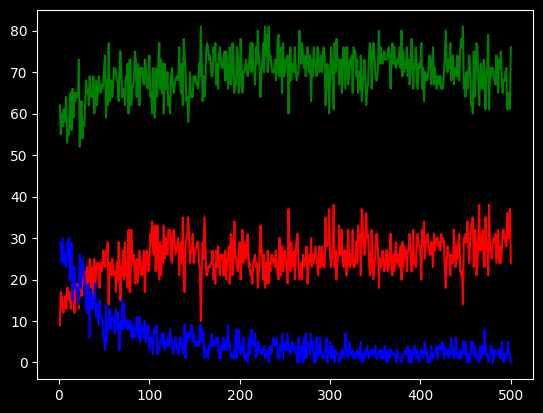

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.DirectPolicyAgent import DirectPolicyAgent

nnplayer = DirectPolicyAgent("PolicyLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer, num_evaluation_batches=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()


Not bad at all. In my runs I would typically get less than 5% losses. Let's try going second agains the Random Player:

After 100 game we have draws: 9, Player 1 wins: 64, and Player 2 wins: 27.
Which gives percentages of draws: 9.00%, Player 1 wins: 64.00%, and Player 2 wins:  27.00%
After 100 game we have draws: 14, Player 1 wins: 61, and Player 2 wins: 25.
Which gives percentages of draws: 14.00%, Player 1 wins: 61.00%, and Player 2 wins:  25.00%
After 100 game we have draws: 12, Player 1 wins: 59, and Player 2 wins: 29.
Which gives percentages of draws: 12.00%, Player 1 wins: 59.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 16, Player 1 wins: 52, and Player 2 wins: 32.
Which gives percentages of draws: 16.00%, Player 1 wins: 52.00%, and Player 2 wins:  32.00%
After 100 game we have draws: 9, Player 1 wins: 71, and Player 2 wins: 20.
Which gives percentages of draws: 9.00%, Player 1 wins: 71.00%, and Player 2 wins:  20.00%
After 100 game we have draws: 19, Player 1 wins: 50, and Player 2 wins: 31.
Which gives percentages of draws: 19.00%, Player 1 wins: 50.00%, and Player 2 wins:  31.

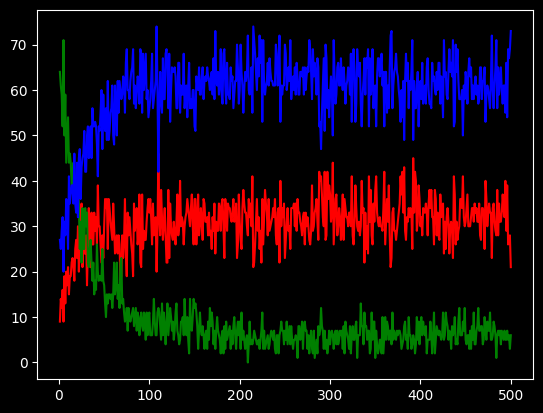

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.DirectPolicyAgent import DirectPolicyAgent

nnplayer = DirectPolicyAgent("PolicyLearner1")
rndplayer = RandomPlayer()

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer, num_evaluation_batches=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()

Not perfect with about 5% to 10% losses, but again a solid performance.

Let's try going first against the non-deterministic Min-Max:

After 100 game we have draws: 21, Player 1 wins: 0, and Player 2 wins: 79.
Which gives percentages of draws: 21.00%, Player 1 wins: 0.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 15, Player 1 wins: 0, and Player 2 wins: 85.
Which gives percentages of draws: 15.00%, Player 1 wins: 0.00%, and Player 2 wins:  85.00%
After 100 game we have draws: 20, Player 1 wins: 0, and Player 2 wins: 80.
Which gives percentages of draws: 20.00%, Player 1 wins: 0.00%, and Player 2 wins:  80.00%
After 100 game we have draws: 21, Player 1 wins: 0, and Player 2 wins: 79.
Which gives percentages of draws: 21.00%, Player 1 wins: 0.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 23, Player 1 wins: 0, and Player 2 wins: 77.
Which gives percentages of draws: 23.00%, Player 1 wins: 0.00%, and Player 2 wins:  77.00%
After 100 game we have draws: 31, Player 1 wins: 0, and Player 2 wins: 69.
Which gives percentages of draws: 31.00%, Player 1 wins: 0.00%, and Player 2 wins:  69.00%
Afte

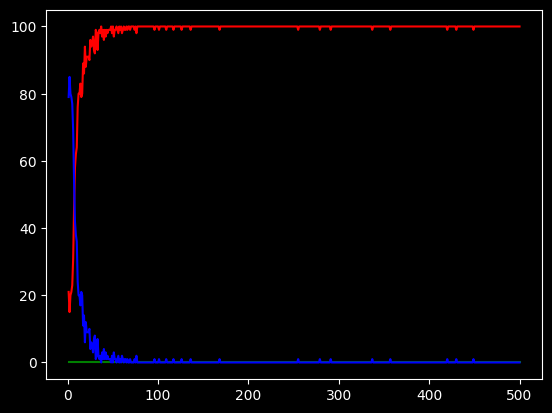

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent
from tic_tac_toe.DirectPolicyAgent import DirectPolicyAgent

nnplayer = DirectPolicyAgent("PolicyLearner1")
rm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rm_player, num_evaluation_batches=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()


Pretty solid again with draws in the 90%. 

Finally going second against the non-deterministic Min Max:

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 6, Player 1 wins: 94, and Player 2 wins: 0.
Which gives percentages of draws: 6.00%, Player 1 wins: 94.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 19, Player 1 wins: 81, and Player 2 wins: 0.
Which gives percentages of draws: 19.00%, Player 1 wins: 81.00%, and Player 2 wins:  0.00%
After 100 ga

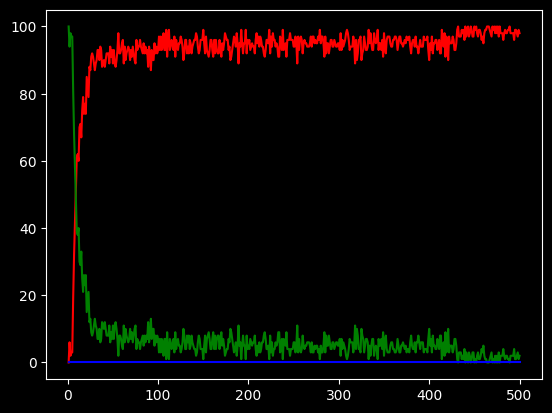

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent
from tic_tac_toe.DirectPolicyAgent import DirectPolicyAgent

nnplayer = DirectPolicyAgent("PolicyLearner1")
rm_player = RndMinMaxAgent()

game_number, p1_wins, p2_wins, draws = evaluate_players(rm_player, nnplayer, num_evaluation_batches=500)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()

Again, surprisingly solid with almost all runs ending in above 90% draws.

## Conclusion
We have introduced Policy Gradient Descent as an alternative method to Q learning as a Reinforcement Learning method. We have also seen how to implement it in Tensorflow in our Tic Tac Toe example.

The results are quite solid, in particular keeping in mind that we did not use Concolutional Layers so far. We don't have a direct comparison with Q learning we also used Loss Regularization which we didn't use in Q-learning without Convolutional layers. So there is a chance that it's really the Loss Regularization that made all the difference, but I doubt it.

Ways to take this further would be:

1. Add Convolutional layers
2. Try Actor Critic Methods

I might get around to trying this in the future. 